In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms as transforms
import torchvision.ops as ops
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import matplotlib.image as mpimg
import json

C:\Users\getto\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = self._get_valid_image_ids()
        
    def _get_valid_image_ids(self):
        # Get image IDs with valid annotations
        valid_ids = []
        for img_id in self.coco.imgs.keys():
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            if len(ann_ids) > 0:
                valid_ids.append(img_id)
        return valid_ids

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path)).convert("RGB")
        
        if len(coco_annotation) == 0:
            # Skip images with no annotations
            return self.__getitem__((index + 1) % len(self.ids))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = []
        # Some objects are almost invisible in images, so we need to remove them from labels
        for i in range(num_objs):
            label = coco_annotation[i]['category_id']
            labels.append(label)
            
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [3]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    #custom_transforms.append(transforms.Normalize([0.112, 0.112, 0.113], [0.112, 0.112, 0.112]))
    return torchvision.transforms.Compose(custom_transforms)

In [4]:
def image_shower(images, labels, n=1):
    for i, image in enumerate(images[:n]):
        fig, ax = plt.subplots(1)
        plt.subplot(n, n, i + 1)
        ax.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
        print(labels[0]['image_id'])
    for box in labels[0]["boxes"]:
        # Extract coordinates
        x_min, y_min, x_max, y_max = box
        print(box)
    
        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min
    
        # Create rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
        # Add rectangle patch to axes
        ax.add_patch(rect)
    ax.set_aspect('equal')
    plt.show()
    print("Real Labels: ", ' '.join('%5s' % classes[label.item()] for label in labels[0]["labels"]))

In [5]:
train_data_dir = './furniture.v3i.coco/train'
train_coco = './furniture.v3i.coco/train/_annotations.coco.json'

my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 10

data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


tensor([658])
tensor([ 62.0000, 112.0000, 577.5000, 523.0000])


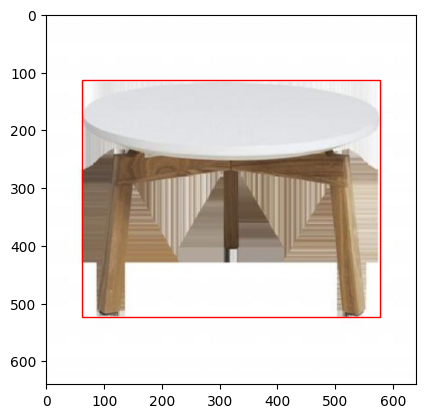

Real Labels:  table


In [6]:
classes = {1:'bed', 2: 'chair', 3:'couch', 4:'table'}
images, labels = next(iter(data_loader))
image_shower(images, labels)

In [7]:
def calculate_iou(box1, box2):
    """
    Calculate IoU between two bounding boxes.

    Parameters:
    - box1 (list or numpy array): [x_min, y_min, x_max, y_max]
    - box2 (list or numpy array): [x_min, y_min, x_max, y_max]

    Returns:
    - IoU (float): Intersection over Union ratio.
    """
    if not isinstance(box1, (list, np.ndarray)) or not isinstance(box2, (list, np.ndarray)):
        raise ValueError("Input boxes must be lists or numpy arrays.")

    x_min_i = max(box1[0], box2[0])
    y_min_i = max(box1[1], box2[1])
    x_max_i = min(box1[2], box2[2])
    y_max_i = min(box1[3], box2[3])

    intersection_area = max(0, x_max_i - x_min_i) * max(0, y_max_i - y_min_i)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area if union_area > 0 else 0.0

    return iou

In [8]:
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error
from tqdm import tqdm as tqdm_notebook

def evaluate(model, data_loader, device, iou_threshold=0.5, nms_threshold=0.1, confidence_threshold=0.5):
    model.eval()
    all_predictions = []
    all_targets = []
    all_iou_per_box = []

    with torch.no_grad():
        for imgs, annotations in tqdm_notebook(data_loader, desc='Validation'):
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

            predictions = model(imgs)
            all_predictions.extend(predictions)
            all_targets.extend(annotations)

    # Extract bounding boxes, labels, and scores from predictions and targets
    pred_boxes = [pred['boxes'].cpu().numpy() for pred in all_predictions]
    pred_labels = [pred['labels'].cpu().numpy() for pred in all_predictions]
    pred_scores = [pred['scores'].cpu().numpy() for pred in all_predictions]

    true_boxes = [target['boxes'].cpu().numpy() for target in all_targets]
    true_labels = [target['labels'].cpu().numpy() for target in all_targets]

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    all_iou_per_box = []

    # Matching strategy based on IoU
    for i in range(len(pred_boxes)):
        # Apply NMS to filter out redundant predictions
        keep = ops.nms(torch.tensor(pred_boxes[i]), torch.tensor(pred_scores[i]), iou_threshold=nms_threshold)
        pred_boxes[i] = pred_boxes[i][keep]
        pred_labels[i] = pred_labels[i][keep]
        pred_scores[i] = pred_scores[i][keep]
        
        if pred_boxes[i].ndim == 2:
            pass
        else:
            pred_boxes[i] = np.array([pred_boxes[i]])
            pred_labels[i] = np.array([pred_labels[i]])
            pred_scores[i] = np.array([pred_scores[i]])
        

        for j in range(len(pred_boxes[i])):
            if pred_scores[i][j] < confidence_threshold:
                continue
            ious = [calculate_iou(pred_boxes[i][j], true_box) for true_box in true_boxes[i]]
            max_iou = max(ious, default=0.0)

            # Check if the maximum IoU is above the threshold
            if max_iou >= iou_threshold:
                true_label = true_labels[i][ious.index(max_iou)]
                predicted_label = pred_labels[i][j]
                all_iou_per_box.append(max_iou)

                if true_label == predicted_label:
                    true_positives += 1
                else:
                    false_positives += 1

                # Remove matched ground truth to avoid double counting
                matched_index = ious.index(max_iou)
                true_boxes[i] = np.delete(true_boxes[i], matched_index, axis=0)
            else:
                false_positives += 1

    # Count unmatched ground truth boxes as false negatives
    for i in range(len(true_boxes)):
        false_negatives += len(true_boxes[i])

    # Calculate accuracy and F1 score based on your logic for true positives, false positives, false negatives, etc.
    total_positives = true_positives + false_negatives
    total_predictions = true_positives + false_positives

    accuracy = true_positives / (true_positives + false_positives + false_negatives) if total_predictions > 0 else 0.0
    precision = true_positives / (true_positives + false_positives) if total_predictions > 0 else 0.0
    recall = true_positives / total_positives if total_positives > 0 else 0.0

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    print(f'TP: {true_positives:.4f}, FP: {false_positives:.4f}, FN: {false_negatives:.4f}')
    print(f'Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}')
    print(f'Average IoU: {np.mean(all_iou_per_box):.4f}')
    return (accuracy, recall, f1, np.mean(all_iou_per_box))

In [9]:
torch.cuda.empty_cache()

In [24]:
valid_data_dir = './furniture.v3i.coco/valid'
valid_coco = './furniture.v3i.coco/valid/_annotations.coco.json'

validation_dataset = myOwnDataset(root=valid_data_dir,
                          annotation=valid_coco,
                          transforms=get_transform()
                          )

validation_data_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=train_batch_size,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [17]:
import mlflow
import mlflow.pytorch

In [18]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("furniture")

<Experiment: artifact_location='file:///C:/Users/getto/Documents/GitHub/FurtnitureRecognition2.0/mlruns/1', creation_time=1706419627204, experiment_id='1', last_update_time=1706419627204, lifecycle_stage='active', name='furniture', tags={}>

In [20]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

# there are 4 types of furniture + background
num_classes = 5
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

with mlflow.start_run(run_name='6th_model'):
    model_params = {
        "momentum": 0.9,
        "lr": 0.002,
        "weight_decay": 0.0005,
        "train_batch_size": 10,
        "num_epochs": 3
    }

    # own DataLoader
    data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=model_params["train_batch_size"],
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

    # parameters
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=model_params["lr"], momentum=model_params["momentum"],
                                weight_decay=model_params["weight_decay"])
    
    len_dataloader = len(data_loader)

    num_epochs = model_params["num_epochs"]
    
    for epoch in range(num_epochs):
        model.train()
        i = 0    
        for imgs, annotations in data_loader:
            
            i += 1
            imgs = list(img.to(device) for img in imgs)
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            
        
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())
    
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
    
            print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
    
    accuracy, recall, f1, average_iou = evaluate(model, validation_data_loader, device, iou_threshold=0.5, nms_threshold=0.1, confidence_threshold=0.6)

    metrics = {
        "accuracy": accuracy,
        "recall": recall,
        "f1": f1,
        "average_iou": average_iou
    }
    # Log parameters
    mlflow.log_params(model_params)

    # Log model
    mlflow.pytorch.log_model(model, 'model6')

    # Log metrics
    mlflow.log_metrics(metrics)

C:\Users\getto\miniconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\getto\miniconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Iteration: 1/262, Loss: 2.5958499908447266
Iteration: 2/262, Loss: 1.3304108381271362
Iteration: 3/262, Loss: 0.6782070994377136
Iteration: 4/262, Loss: 0.4215673804283142
Iteration: 5/262, Loss: 0.4298504590988159
Iteration: 6/262, Loss: 0.3497217893600464
Iteration: 7/262, Loss: 0.33665624260902405
Iteration: 8/262, Loss: 0.5064771771430969
Iteration: 9/262, Loss: 0.4472302198410034
Iteration: 10/262, Loss: 0.570365309715271
Iteration: 11/262, Loss: 0.44186416268348694
Iteration: 12/262, Loss: 0.3331451714038849
Iteration: 13/262, Loss: 0.4107581079006195
Iteration: 14/262, Loss: 0.30007752776145935
Iteration: 15/262, Loss: 0.3450988233089447
Iteration: 16/262, Loss: 0.4664141535758972
Iteration: 17/262, Loss: 0.4292619526386261
Iteration: 18/262, Loss: 0.2975383698940277
Iteration: 19/262, Loss: 0.24168309569358826
Iteration: 20/262, Loss: 0.2363029569387436
Iteration: 21/262, Loss: 0.24583518505096436
Iteration: 22/262, Loss: 0.30288106203079224
Iteration: 23/262, Loss: 0.227034166

Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [01:59<00:00,  2.99s/it]


TP: 386.0000, FP: 33.0000, FN: 64.0000
Accuracy: 0.7992, Recall: 0.8578, F1 Score: 0.8884
Average IoU: 0.8653


2024/01/28 09:43:13 WARNING mlflow.utils.requirements_utils: Found torch version (2.1.2+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.1.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/01/28 09:43:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.16.2+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.16.2' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [22]:
logged_model = 'runs:/bd3cb1b54c2b43018a8df243d05cd566/model6'

model = mlflow.pytorch.load_model(logged_model)

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [25]:
accuracy, recall, f1, average_iou = evaluate(model, validation_data_loader, device, iou_threshold=0.5, nms_threshold=0.07, confidence_threshold=0.6)

Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.70it/s]

TP: 386.0000, FP: 28.0000, FN: 65.0000
Accuracy: 0.8058, Recall: 0.8559, F1 Score: 0.8925
Average IoU: 0.8653


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.81it/s]


TP: 390.0000, FP: 29.0000, FN: 58.0000
Accuracy: 0.8176, Recall: 0.8705, F1 Score: 0.8997
Average IoU: 0.8609


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 391.0000, FP: 41.0000, FN: 55.0000
Accuracy: 0.8029, Recall: 0.8767, F1 Score: 0.8907
Average IoU: 0.8603


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 395.0000, FP: 50.0000, FN: 50.0000
Accuracy: 0.7980, Recall: 0.8876, F1 Score: 0.8876
Average IoU: 0.8594


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 398.0000, FP: 55.0000, FN: 45.0000
Accuracy: 0.7992, Recall: 0.8984, F1 Score: 0.8884
Average IoU: 0.8585


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 400.0000, FP: 58.0000, FN: 43.0000
Accuracy: 0.7984, Recall: 0.9029, F1 Score: 0.8879
Average IoU: 0.8582


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.79it/s]


TP: 389.0000, FP: 28.0000, FN: 59.0000
Accuracy: 0.8172, Recall: 0.8683, F1 Score: 0.8994
Average IoU: 0.8615


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 390.0000, FP: 39.0000, FN: 57.0000
Accuracy: 0.8025, Recall: 0.8725, F1 Score: 0.8904
Average IoU: 0.8611


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 394.0000, FP: 45.0000, FN: 52.0000
Accuracy: 0.8024, Recall: 0.8834, F1 Score: 0.8904
Average IoU: 0.8602


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.79it/s]


TP: 397.0000, FP: 47.0000, FN: 48.0000
Accuracy: 0.8069, Recall: 0.8921, F1 Score: 0.8931
Average IoU: 0.8599


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 399.0000, FP: 48.0000, FN: 46.0000
Accuracy: 0.8093, Recall: 0.8966, F1 Score: 0.8946
Average IoU: 0.8595


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 389.0000, FP: 23.0000, FN: 62.0000
Accuracy: 0.8207, Recall: 0.8625, F1 Score: 0.9015
Average IoU: 0.8622


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 389.0000, FP: 30.0000, FN: 61.0000
Accuracy: 0.8104, Recall: 0.8644, F1 Score: 0.8953
Average IoU: 0.8622


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 393.0000, FP: 36.0000, FN: 56.0000
Accuracy: 0.8103, Recall: 0.8753, F1 Score: 0.8952
Average IoU: 0.8612


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 396.0000, FP: 37.0000, FN: 52.0000
Accuracy: 0.8165, Recall: 0.8839, F1 Score: 0.8990
Average IoU: 0.8609


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 398.0000, FP: 38.0000, FN: 50.0000
Accuracy: 0.8189, Recall: 0.8884, F1 Score: 0.9005
Average IoU: 0.8605


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 386.0000, FP: 19.0000, FN: 68.0000
Accuracy: 0.8161, Recall: 0.8502, F1 Score: 0.8987
Average IoU: 0.8628


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.76it/s]


TP: 386.0000, FP: 24.0000, FN: 67.0000
Accuracy: 0.8092, Recall: 0.8521, F1 Score: 0.8946
Average IoU: 0.8628


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 390.0000, FP: 26.0000, FN: 63.0000
Accuracy: 0.8142, Recall: 0.8609, F1 Score: 0.8976
Average IoU: 0.8624


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 392.0000, FP: 27.0000, FN: 60.0000
Accuracy: 0.8184, Recall: 0.8673, F1 Score: 0.9001
Average IoU: 0.8622


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 393.0000, FP: 27.0000, FN: 59.0000
Accuracy: 0.8205, Recall: 0.8695, F1 Score: 0.9014
Average IoU: 0.8618


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 375.0000, FP: 15.0000, FN: 81.0000
Accuracy: 0.7962, Recall: 0.8224, F1 Score: 0.8865
Average IoU: 0.8638


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 375.0000, FP: 17.0000, FN: 81.0000
Accuracy: 0.7928, Recall: 0.8224, F1 Score: 0.8844
Average IoU: 0.8638


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 379.0000, FP: 18.0000, FN: 77.0000
Accuracy: 0.7996, Recall: 0.8311, F1 Score: 0.8886
Average IoU: 0.8633


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 380.0000, FP: 18.0000, FN: 76.0000
Accuracy: 0.8017, Recall: 0.8333, F1 Score: 0.8899
Average IoU: 0.8635


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.74it/s]


TP: 380.0000, FP: 18.0000, FN: 76.0000
Accuracy: 0.8017, Recall: 0.8333, F1 Score: 0.8899
Average IoU: 0.8635


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 387.0000, FP: 32.0000, FN: 62.0000
Accuracy: 0.8046, Recall: 0.8619, F1 Score: 0.8917
Average IoU: 0.8649


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 388.0000, FP: 44.0000, FN: 59.0000
Accuracy: 0.7902, Recall: 0.8680, F1 Score: 0.8828
Average IoU: 0.8642


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 392.0000, FP: 53.0000, FN: 54.0000
Accuracy: 0.7856, Recall: 0.8789, F1 Score: 0.8799
Average IoU: 0.8633


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 395.0000, FP: 58.0000, FN: 49.0000
Accuracy: 0.7869, Recall: 0.8896, F1 Score: 0.8807
Average IoU: 0.8623


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 397.0000, FP: 61.0000, FN: 47.0000
Accuracy: 0.7861, Recall: 0.8941, F1 Score: 0.8803
Average IoU: 0.8620


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.75it/s]


TP: 386.0000, FP: 31.0000, FN: 63.0000
Accuracy: 0.8042, Recall: 0.8597, F1 Score: 0.8915
Average IoU: 0.8655


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 387.0000, FP: 42.0000, FN: 61.0000
Accuracy: 0.7898, Recall: 0.8638, F1 Score: 0.8826
Average IoU: 0.8651


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 391.0000, FP: 48.0000, FN: 56.0000
Accuracy: 0.7899, Recall: 0.8747, F1 Score: 0.8826
Average IoU: 0.8641


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 394.0000, FP: 50.0000, FN: 52.0000
Accuracy: 0.7944, Recall: 0.8834, F1 Score: 0.8854
Average IoU: 0.8637


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 396.0000, FP: 51.0000, FN: 50.0000
Accuracy: 0.7968, Recall: 0.8879, F1 Score: 0.8869
Average IoU: 0.8634


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 386.0000, FP: 26.0000, FN: 65.0000
Accuracy: 0.8092, Recall: 0.8559, F1 Score: 0.8946
Average IoU: 0.8653


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.76it/s]


TP: 386.0000, FP: 33.0000, FN: 64.0000
Accuracy: 0.7992, Recall: 0.8578, F1 Score: 0.8884
Average IoU: 0.8653


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.75it/s]


TP: 390.0000, FP: 39.0000, FN: 59.0000
Accuracy: 0.7992, Recall: 0.8686, F1 Score: 0.8884
Average IoU: 0.8643


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 393.0000, FP: 40.0000, FN: 55.0000
Accuracy: 0.8053, Recall: 0.8772, F1 Score: 0.8922
Average IoU: 0.8639


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.76it/s]


TP: 395.0000, FP: 41.0000, FN: 53.0000
Accuracy: 0.8078, Recall: 0.8817, F1 Score: 0.8937
Average IoU: 0.8635


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]


TP: 383.0000, FP: 22.0000, FN: 71.0000
Accuracy: 0.8046, Recall: 0.8436, F1 Score: 0.8917
Average IoU: 0.8660


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.68it/s]


TP: 383.0000, FP: 27.0000, FN: 70.0000
Accuracy: 0.7979, Recall: 0.8455, F1 Score: 0.8876
Average IoU: 0.8659


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:23<00:00,  1.67it/s]


TP: 387.0000, FP: 29.0000, FN: 66.0000
Accuracy: 0.8029, Recall: 0.8543, F1 Score: 0.8907
Average IoU: 0.8655


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 389.0000, FP: 30.0000, FN: 63.0000
Accuracy: 0.8071, Recall: 0.8606, F1 Score: 0.8932
Average IoU: 0.8653


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 390.0000, FP: 30.0000, FN: 62.0000
Accuracy: 0.8091, Recall: 0.8628, F1 Score: 0.8945
Average IoU: 0.8649


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 372.0000, FP: 18.0000, FN: 84.0000
Accuracy: 0.7848, Recall: 0.8158, F1 Score: 0.8794
Average IoU: 0.8670


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 372.0000, FP: 20.0000, FN: 84.0000
Accuracy: 0.7815, Recall: 0.8158, F1 Score: 0.8774
Average IoU: 0.8670


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 376.0000, FP: 21.0000, FN: 80.0000
Accuracy: 0.7883, Recall: 0.8246, F1 Score: 0.8816
Average IoU: 0.8666


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 377.0000, FP: 21.0000, FN: 79.0000
Accuracy: 0.7904, Recall: 0.8268, F1 Score: 0.8829
Average IoU: 0.8668


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 377.0000, FP: 21.0000, FN: 79.0000
Accuracy: 0.7904, Recall: 0.8268, F1 Score: 0.8829
Average IoU: 0.8668


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 378.0000, FP: 41.0000, FN: 71.0000
Accuracy: 0.7714, Recall: 0.8419, F1 Score: 0.8710
Average IoU: 0.8720


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.78it/s]


TP: 379.0000, FP: 53.0000, FN: 68.0000
Accuracy: 0.7580, Recall: 0.8479, F1 Score: 0.8623
Average IoU: 0.8713


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 383.0000, FP: 62.0000, FN: 63.0000
Accuracy: 0.7539, Recall: 0.8587, F1 Score: 0.8597
Average IoU: 0.8703


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 386.0000, FP: 67.0000, FN: 58.0000
Accuracy: 0.7554, Recall: 0.8694, F1 Score: 0.8606
Average IoU: 0.8692


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 388.0000, FP: 70.0000, FN: 56.0000
Accuracy: 0.7549, Recall: 0.8739, F1 Score: 0.8603
Average IoU: 0.8688


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 377.0000, FP: 40.0000, FN: 72.0000
Accuracy: 0.7710, Recall: 0.8396, F1 Score: 0.8707
Average IoU: 0.8727


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 378.0000, FP: 51.0000, FN: 70.0000
Accuracy: 0.7575, Recall: 0.8438, F1 Score: 0.8620
Average IoU: 0.8723


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 382.0000, FP: 57.0000, FN: 65.0000
Accuracy: 0.7579, Recall: 0.8546, F1 Score: 0.8623
Average IoU: 0.8712


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 385.0000, FP: 59.0000, FN: 61.0000
Accuracy: 0.7624, Recall: 0.8632, F1 Score: 0.8652
Average IoU: 0.8707


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 387.0000, FP: 60.0000, FN: 59.0000
Accuracy: 0.7648, Recall: 0.8677, F1 Score: 0.8667
Average IoU: 0.8703


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.67it/s]


TP: 377.0000, FP: 35.0000, FN: 74.0000
Accuracy: 0.7757, Recall: 0.8359, F1 Score: 0.8737
Average IoU: 0.8726


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.62it/s]


TP: 377.0000, FP: 42.0000, FN: 73.0000
Accuracy: 0.7663, Recall: 0.8378, F1 Score: 0.8677
Average IoU: 0.8725


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:24<00:00,  1.63it/s]


TP: 381.0000, FP: 48.0000, FN: 68.0000
Accuracy: 0.7666, Recall: 0.8486, F1 Score: 0.8679
Average IoU: 0.8714


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.74it/s]


TP: 384.0000, FP: 49.0000, FN: 64.0000
Accuracy: 0.7726, Recall: 0.8571, F1 Score: 0.8717
Average IoU: 0.8709


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 386.0000, FP: 50.0000, FN: 62.0000
Accuracy: 0.7751, Recall: 0.8616, F1 Score: 0.8733
Average IoU: 0.8705


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.76it/s]


TP: 374.0000, FP: 31.0000, FN: 80.0000
Accuracy: 0.7711, Recall: 0.8238, F1 Score: 0.8708
Average IoU: 0.8734


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.75it/s]


TP: 374.0000, FP: 36.0000, FN: 79.0000
Accuracy: 0.7648, Recall: 0.8256, F1 Score: 0.8667
Average IoU: 0.8733


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 378.0000, FP: 38.0000, FN: 75.0000
Accuracy: 0.7699, Recall: 0.8344, F1 Score: 0.8700
Average IoU: 0.8727


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 380.0000, FP: 39.0000, FN: 72.0000
Accuracy: 0.7739, Recall: 0.8407, F1 Score: 0.8726
Average IoU: 0.8725


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 381.0000, FP: 39.0000, FN: 71.0000
Accuracy: 0.7760, Recall: 0.8429, F1 Score: 0.8739
Average IoU: 0.8720


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 364.0000, FP: 26.0000, FN: 92.0000
Accuracy: 0.7552, Recall: 0.7982, F1 Score: 0.8605
Average IoU: 0.8739


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.76it/s]


TP: 364.0000, FP: 28.0000, FN: 92.0000
Accuracy: 0.7521, Recall: 0.7982, F1 Score: 0.8585
Average IoU: 0.8739


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 368.0000, FP: 29.0000, FN: 88.0000
Accuracy: 0.7588, Recall: 0.8070, F1 Score: 0.8628
Average IoU: 0.8734


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 369.0000, FP: 29.0000, FN: 87.0000
Accuracy: 0.7608, Recall: 0.8092, F1 Score: 0.8642
Average IoU: 0.8736


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 369.0000, FP: 29.0000, FN: 87.0000
Accuracy: 0.7608, Recall: 0.8092, F1 Score: 0.8642
Average IoU: 0.8736


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 365.0000, FP: 54.0000, FN: 85.0000
Accuracy: 0.7242, Recall: 0.8111, F1 Score: 0.8400
Average IoU: 0.8796


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 366.0000, FP: 66.0000, FN: 82.0000
Accuracy: 0.7121, Recall: 0.8170, F1 Score: 0.8318
Average IoU: 0.8788


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 370.0000, FP: 75.0000, FN: 78.0000
Accuracy: 0.7075, Recall: 0.8259, F1 Score: 0.8287
Average IoU: 0.8782


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 373.0000, FP: 80.0000, FN: 74.0000
Accuracy: 0.7078, Recall: 0.8345, F1 Score: 0.8289
Average IoU: 0.8776


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 374.0000, FP: 84.0000, FN: 73.0000
Accuracy: 0.7043, Recall: 0.8367, F1 Score: 0.8265
Average IoU: 0.8777


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 365.0000, FP: 52.0000, FN: 85.0000
Accuracy: 0.7271, Recall: 0.8111, F1 Score: 0.8420
Average IoU: 0.8796


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 366.0000, FP: 63.0000, FN: 83.0000
Accuracy: 0.7148, Recall: 0.8151, F1 Score: 0.8337
Average IoU: 0.8791


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.76it/s]


TP: 370.0000, FP: 69.0000, FN: 79.0000
Accuracy: 0.7143, Recall: 0.8241, F1 Score: 0.8333
Average IoU: 0.8785


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 373.0000, FP: 71.0000, FN: 75.0000
Accuracy: 0.7187, Recall: 0.8326, F1 Score: 0.8363
Average IoU: 0.8779


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.77it/s]


TP: 374.0000, FP: 73.0000, FN: 74.0000
Accuracy: 0.7179, Recall: 0.8348, F1 Score: 0.8358
Average IoU: 0.8780


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:22<00:00,  1.79it/s]


TP: 365.0000, FP: 47.0000, FN: 87.0000
Accuracy: 0.7315, Recall: 0.8075, F1 Score: 0.8449
Average IoU: 0.8795


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.82it/s]


TP: 365.0000, FP: 54.0000, FN: 86.0000
Accuracy: 0.7228, Recall: 0.8093, F1 Score: 0.8391
Average IoU: 0.8794


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.82it/s]


TP: 369.0000, FP: 60.0000, FN: 82.0000
Accuracy: 0.7221, Recall: 0.8182, F1 Score: 0.8386
Average IoU: 0.8788


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 372.0000, FP: 61.0000, FN: 78.0000
Accuracy: 0.7280, Recall: 0.8267, F1 Score: 0.8426
Average IoU: 0.8782


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 373.0000, FP: 63.0000, FN: 77.0000
Accuracy: 0.7271, Recall: 0.8289, F1 Score: 0.8420
Average IoU: 0.8783


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 363.0000, FP: 42.0000, FN: 91.0000
Accuracy: 0.7319, Recall: 0.7996, F1 Score: 0.8452
Average IoU: 0.8794


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 363.0000, FP: 47.0000, FN: 90.0000
Accuracy: 0.7260, Recall: 0.8013, F1 Score: 0.8413
Average IoU: 0.8793


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.82it/s]


TP: 367.0000, FP: 49.0000, FN: 86.0000
Accuracy: 0.7311, Recall: 0.8102, F1 Score: 0.8446
Average IoU: 0.8786


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 369.0000, FP: 50.0000, FN: 83.0000
Accuracy: 0.7351, Recall: 0.8164, F1 Score: 0.8473
Average IoU: 0.8784


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 369.0000, FP: 51.0000, FN: 83.0000
Accuracy: 0.7336, Recall: 0.8164, F1 Score: 0.8463
Average IoU: 0.8784


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.82it/s]


TP: 353.0000, FP: 37.0000, FN: 103.0000
Accuracy: 0.7160, Recall: 0.7741, F1 Score: 0.8345
Average IoU: 0.8802


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 353.0000, FP: 39.0000, FN: 103.0000
Accuracy: 0.7131, Recall: 0.7741, F1 Score: 0.8325
Average IoU: 0.8802


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 357.0000, FP: 40.0000, FN: 99.0000
Accuracy: 0.7198, Recall: 0.7829, F1 Score: 0.8370
Average IoU: 0.8795


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 358.0000, FP: 40.0000, FN: 98.0000
Accuracy: 0.7218, Recall: 0.7851, F1 Score: 0.8384
Average IoU: 0.8797


Validation: 100%|██████████████████████████████████████████████████████████████████████| 40/40 [00:21<00:00,  1.83it/s]


TP: 358.0000, FP: 40.0000, FN: 98.0000
Accuracy: 0.7218, Recall: 0.7851, F1 Score: 0.8384
Average IoU: 0.8797


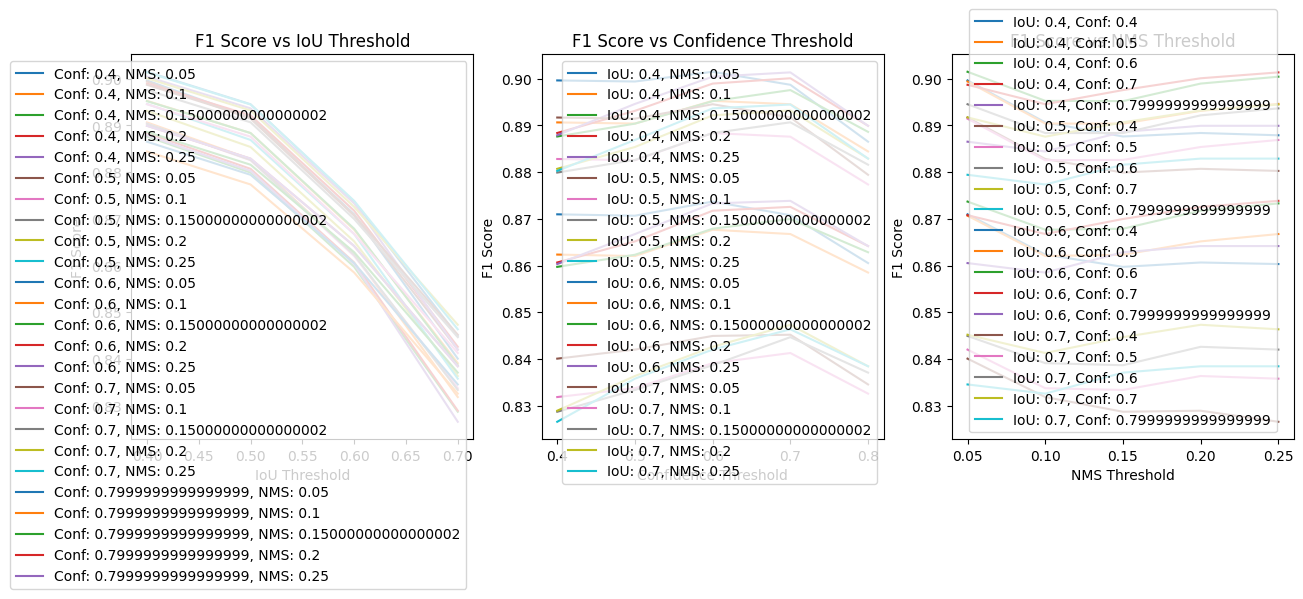

In [27]:
def evaluate_with_parameters(model, data_loader, device, iou_threshold, nms_threshold, confidence_threshold):
    return evaluate(model, data_loader, device, iou_threshold, nms_threshold, confidence_threshold)[2]  # Extracting F1 score

iou_thresholds = np.arange(0.4, 0.8, 0.1)
confidence_thresholds = np.arange(0.4, 0.9, 0.1)
nms_thresholds = np.arange(0.05, 0.3, 0.05)

f1_scores = np.zeros((len(iou_thresholds), len(confidence_thresholds), len(nms_thresholds)))

# Loop through different parameter values and compute F1 score
for i, iou_thresh in enumerate(iou_thresholds):
    for j, confidence_thresh in enumerate(confidence_thresholds):
        for k, nms_thresh in enumerate(nms_thresholds):
            f1_scores[i, j, k] = evaluate_with_parameters(model, validation_data_loader, device,
                                                          iou_thresh, nms_thresh, confidence_thresh)

Best F1 Score: 0.9015
Corresponding Parameters:
IoU Threshold: 0.40
Confidence Threshold: 0.60
NMS Threshold: 0.05


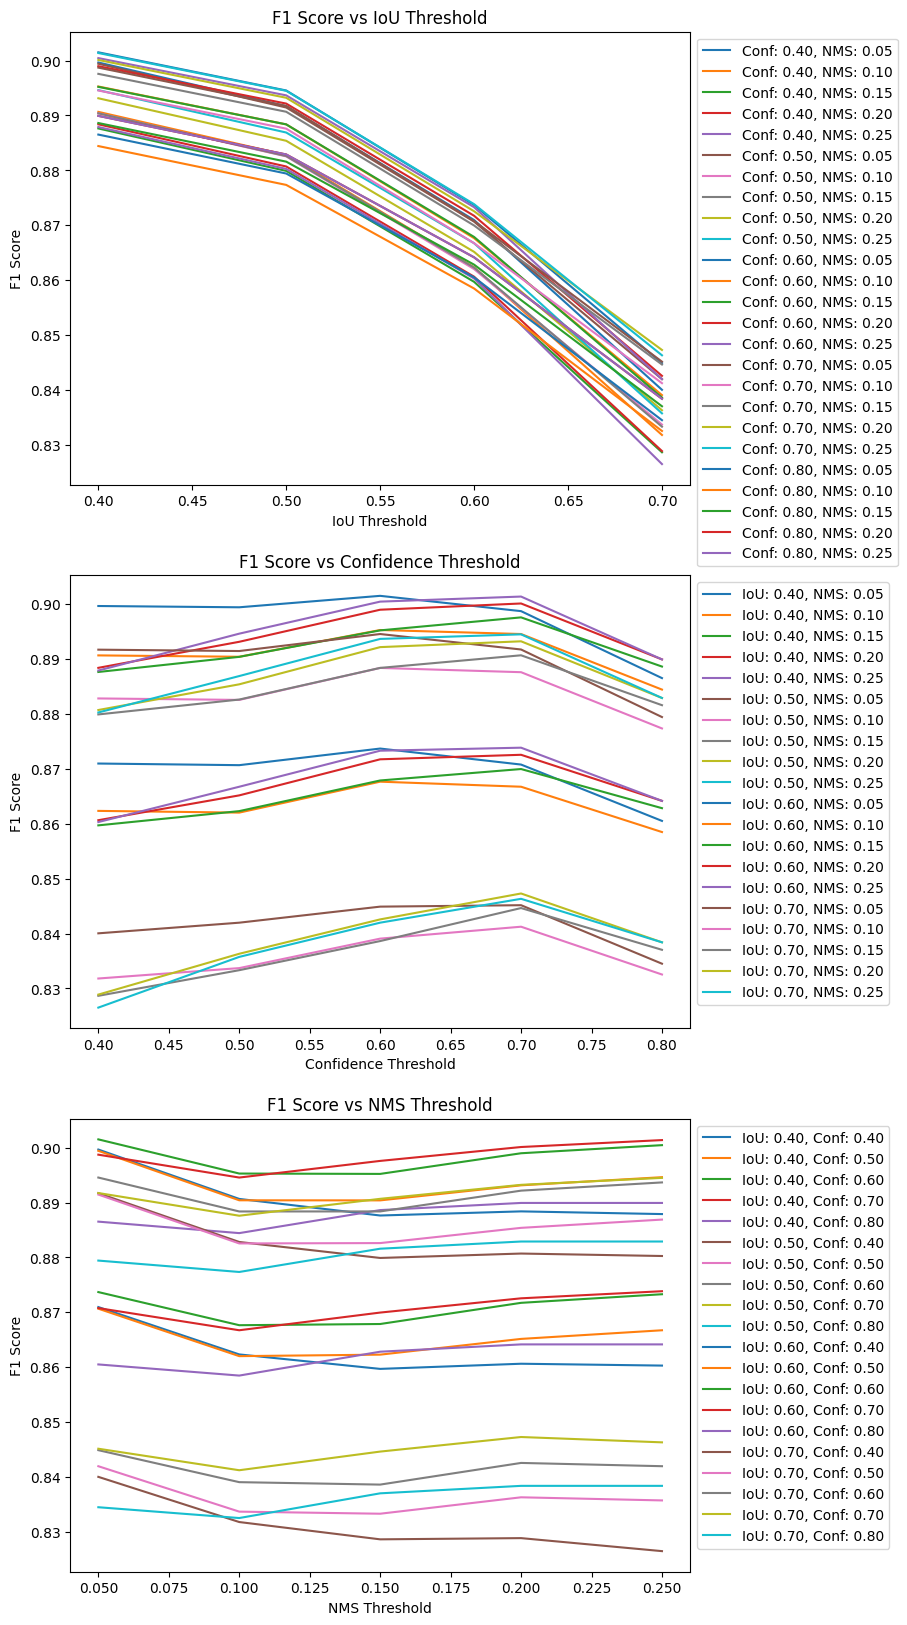

In [33]:
best_indices = np.unravel_index(np.argmax(f1_scores), f1_scores.shape)

best_iou_threshold = iou_thresholds[best_indices[0]]
best_confidence_threshold = confidence_thresholds[best_indices[1]]
best_nms_threshold = nms_thresholds[best_indices[2]]
best_f1_score = f1_scores[best_indices]

print(f"Best F1 Score: {best_f1_score:.4f}")
print(f"Corresponding Parameters:")
print(f"IoU Threshold: {best_iou_threshold:.2f}")
print(f"Confidence Threshold: {best_confidence_threshold:.2f}")
print(f"NMS Threshold: {best_nms_threshold:.2f}")

fig, ax = plt.subplots(3, 1, figsize=(8, 20))

# Plot for IoU Threshold
for i in range(len(confidence_thresholds)):
    for j in range(len(nms_thresholds)):
        label = f'Conf: {confidence_thresholds[i]:.2f}, NMS: {nms_thresholds[j]:.2f}'
        ax[0].plot(iou_thresholds, f1_scores[:, i, j], label=label)
ax[0].set_title('F1 Score vs IoU Threshold')
ax[0].set_xlabel('IoU Threshold')
ax[0].set_ylabel('F1 Score')
ax[0].legend(loc='upper left', bbox_to_anchor=(1, 1)) 

# Plot for Confidence Threshold
for i in range(len(iou_thresholds)):
    for j in range(len(nms_thresholds)):
        label = f'IoU: {iou_thresholds[i]:.2f}, NMS: {nms_thresholds[j]:.2f}'
        ax[1].plot(confidence_thresholds, f1_scores[i, :, j], label=label)
ax[1].set_title('F1 Score vs Confidence Threshold')
ax[1].set_xlabel('Confidence Threshold')
ax[1].set_ylabel('F1 Score')
ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot for NMS Threshold
for i in range(len(iou_thresholds)):
    for j in range(len(confidence_thresholds)):
        label = f'IoU: {iou_thresholds[i]:.2f}, Conf: {confidence_thresholds[j]:.2f}'
        ax[2].plot(nms_thresholds, f1_scores[i, j, :], label=label)
ax[2].set_title('F1 Score vs NMS Threshold')
ax[2].set_xlabel('NMS Threshold')
ax[2].set_ylabel('F1 Score')
ax[2].legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

In [10]:
def get_transform_test():
    custom_transforms = []
    #custom_transforms.append(torchvision.transforms.Resize((640, 640)))
    custom_transforms.append(torchvision.transforms.ToTensor())
    #custom_transforms.append(transforms.Normalize([0.162, 0.162, 0.163], [0.112, 0.112, 0.112]))
    return torchvision.transforms.Compose(custom_transforms)

In [12]:
import random

def visualize_prediction(model, data_loader, device, num_images=1, iou_threshold=0.5, confidence_threshold=0.5):
    model.eval()

    classes = {1:'bed', 2: 'chair', 3:'couch', 4:'table'}
    # Get a batch of random images from the validation dataset
    random_images, random_annotations = zip(*random.sample(list(data_loader.dataset), num_images))
    random_images = [img.to(device) for img in random_images]

    with torch.no_grad():
        predictions = model(random_images)

    for i in range(num_images):
        img = random_images[i].cpu().numpy().transpose((1, 2, 0))
        fig, ax = plt.subplots(1)
        ax.imshow(img)

        keep = ops.nms(predictions[i]['boxes'], predictions[i]['scores'], iou_threshold)
        filtered_boxes = predictions[i]['boxes'][keep]
        filtered_scores = predictions[i]['scores'][keep]
        filtered_labels = predictions[i]['labels'][keep]

        for box in random_annotations[i]['boxes']:
            xmin, ymin, xmax, ymax = box.cpu().numpy()
            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

        for box, score, label in zip(filtered_boxes, filtered_scores, filtered_labels):
            if score >= confidence_threshold:
                xmin, ymin, xmax, ymax = box.cpu().numpy()
                rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(xmin, ymin, f'{classes[label.item()]} {score:.2f}', fontsize=8, bbox=dict(facecolor='yellow', alpha=0.5))

        plt.show()

In [13]:
visualize_prediction(model, data_loader, device, num_images=10, iou_threshold=0.07, confidence_threshold=0.8)

NameError: name 'model' is not defined